# THIRD PROJECT

## Exploring the USA's milk imports and exports in the whole of 2020

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the USA's imports and exports of milk and cream in 2020:

How much does the US export and import and is the balance positive (more exports than imports)?
Which are the main trading partners, i.e. from/to which countries does the US import/export the most?
Which are the regular customers, i.e. which countries buy milk from the US every month?
Which countries does the US both import from and export to?

#### GETTING THE DATASET

The data is obtained from the United Nations Comtrade website, by selecting the following configuration:

Type of Product: 
goods
Frequency: 
monthly
Periods: 
January to May of 2020
Reporter: United States
Partners: all
Flows: imports and exports
HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)

Clicking on 'Preview' results in a message that the data exceeds 500 rows. Data was downloaded using the Download CSV button and the download file renamed appropriately.

In [14]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import pandas as pd

from pandas import *
%matplotlib inline



In [15]:
LOCATION = 'comtrade_milk_usa_all_of_2020.csv'
#LOCATION.head(2)

The data can also be downloaded directly from Comtrade using the "View API Call" URL, modified in two ways:

max=500 is increased to max=5000 to make sure all data is loaded,
&fmt=csv is added at the end to obtain the data in CSV format.

In [16]:
#http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=2020&r=842&p=all&rg=1%2C2&cc=0401%2C0402&fmt=csv

In [17]:
milk = read_csv(LOCATION, dtype={'Commodity Code':str})
milk.tail(2)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
1483,HS,2020,202012,Dec-20,4,0,2,Exports,842,United States of America,...,NaN,NaN,NaN,NaN,2188.0,NaN,12362,NaN,NaN,0
1484,HS,2020,202012,Dec-20,4,0,2,Exports,842,United States of America,...,NaN,NaN,NaN,NaN,41373.0,NaN,53664,NaN,NaN,0


In [18]:
def milkType(code):
    if code == '401': # neither concentrated nor sweetened
        return 'unprocessed'
    if code == '402': # concentrated or sweetened
        return 'processed' 
    return 'unknown'

COMMODITY = 'Milk and cream'
milk[COMMODITY] = milk['Commodity Code'].apply(milkType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
milk = milk[headings]
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,202009,Italy,Imports,unprocessed,146037
1,202009,Mexico,Imports,unprocessed,3154731
2,202009,Ireland,Imports,unprocessed,129421
3,202009,Australia,Imports,unprocessed,203038
4,202009,Japan,Imports,unprocessed,3870


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [19]:
milk = milk[milk[PARTNER] != 'World']
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,202009,Italy,Imports,unprocessed,146037
1,202009,Mexico,Imports,unprocessed,3154731
2,202009,Ireland,Imports,unprocessed,129421
3,202009,Australia,Imports,unprocessed,203038
4,202009,Japan,Imports,unprocessed,3870


In [22]:
milk_world = milk[milk['Partner'] == 'World']
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,202009,Italy,Imports,unprocessed,146037
1,202009,Mexico,Imports,unprocessed,3154731
2,202009,Ireland,Imports,unprocessed,129421
3,202009,Australia,Imports,unprocessed,203038
4,202009,Japan,Imports,unprocessed,3870


Total trade flow
To answer the first question, 'how much does USA export and import and is the balance positive (more exports than imports)?', the dataframe is split into two groups: exports from the USA and imports into the USA. The trade values within each group are summed up to get the total trading.

In [21]:
grouped = milk.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports    2290845588
Imports     190392021
Name: Trade Value (US$), dtype: int64

This shows a trade surplus of over 100 million dollars.

### Main trade partners
To address the second question, 'Which are the main trading partners, i.e. from/to which countries does USA import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top

In [24]:
imports = milk[milk[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('The USA imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to USA are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

The USA imports from 45 countries.
The 5 biggest exporters to USA are:


Partner
Mexico         89869140
Canada         25434222
Chile          24215616
Netherlands    21670160
New Zealand     9141116
Name: Trade Value (US$), dtype: int64

In [27]:
milk_imports = milk[milk['Trade Flow'] == 'Imports']
milk_countries_imports = milk[milk['Trade Flow'] == 'Imports']
milk_world_imports=milk_world[milk_world['Trade Flow'] == 'Imports']

The export values can be plotted as a bar chart, making differences between countries easier to see.

<AxesSubplot:ylabel='Partner'>

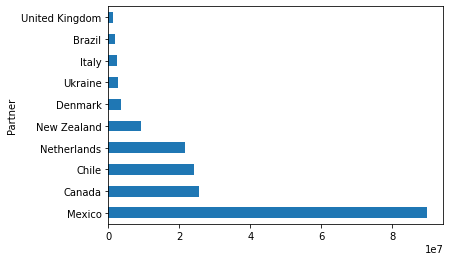

In [41]:
totalImports.head(10).plot(kind='barh',grid=False)

In [42]:
exports = milk[milk[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('USA exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the USA are:')
grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).head()

USA exports to 108 countries.
The 5 biggest importers from the USA are:


Partner
Mexico         756995616
Philippines    285133777
Indonesia      251612706
Viet Nam       133761818
Malaysia       110730412
Name: Trade Value (US$), dtype: int64

Regular importers
Given that there are two commodities, the third question, 'Which are the regular customers, i.e. which countries buy milk from the UK every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [43]:
def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 202001) & (regular[COMMODITY] == 'processed')]

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
477,202001,Cambodia,Exports,processed,420000
489,202001,Germany,Exports,processed,10026
490,202001,Ghana,Exports,processed,689850
494,202001,Haiti,Exports,processed,60227
498,202001,Israel,Exports,processed,331835


Just over 75% of the total USA exports are due to these regular customers.

In [44]:
regular[VALUE].sum() / exports[VALUE].sum()

0.008085764093847777

Bi-directional trade
To address the fourth question, 'Which countries does USA  both import from and export to?', a pivot table is used to list the total export and import value for each country.

In [47]:
countries = pivot_table(milk, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
Afghanistan,5856675.0,NaN
Algeria,17097603.0,NaN
Anguilla,102015.0,NaN
Antigua and Barbuda,105409.0,NaN
Argentina,137293.0,NaN


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the USA.

In [48]:
countries.dropna()

Trade Flow,Exports,Imports
Partner,,
Australia,1938038.0,890587.0
Belarus,35000.0,7273.0
Belgium,2560.0,9975.0
Brazil,4530782.0,1842618.0
Canada,47451380.0,25434222.0
Chile,25565174.0,24215616.0
Costa Rica,1109364.0,227756.0
Ecuador,221089.0,3891.0
Fiji,19825.0,13731.0


Conclusions
The milk and cream trade of the UK from January to May 2015 was analysed in terms of which countries the UK mostly depends on for income (exports) and goods (imports). Over the period, the UK had a trade surplus of over 100 million US dollars.

Ireland is the main partner, but it imported from the UK almost the triple in value than it exported to the UK.

The UK exported to over 100 countries during the period, but only imported from 21 countries, the main ones (top five by trade value) being geographically close. China and Hong Kong are the main importers that are not also main exporters.

The UK is heavily dependent on its regular customers, the 16 countries that buy all types of milk and cream every month. They contribute three quarters of the total export value.

The UK has bi-directional trade (i.e. both exports and imports) with 20 countries, although for some the trade value (in US dollars) is suspiciously low, which raises questions about the data's accuracy.